### LNM Models - Airbnb listing prices
#### Sanchi Arora, Lian Liu, Josefina Bollini

In [1]:
import pandas as pd
import numpy as np
from numpy import *
from sklearn.model_selection import train_test_split

model_data = pd.read_csv('model_data_dummies.csv',low_memory=False)

In [2]:
print(model_data.columns)

Index(['description', 'neighborhood_overview', 'host_id', 'host_since',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'neighbourhood',
       ...
       'Generic body soap', 'city_Chicago', 'city_Los angeles',
       'city_New York', 'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'topic_comments_word_0',
       'topic_comments_word_close_apartment_good',
       'topic_comments_word_space_neighborhood'],
      dtype='object', length=365)


In [3]:
# Drop variables: 
model_data_clean = model_data.drop(['description', 'neighborhood_overview', 'host_id', 'host_since',
                                   'host_response_time', 'host_response_rate', 'host_acceptance_rate',
                                   'calculated_host_listings_count','neighbourhood',
                                   'calculated_host_listings_count_entire_homes',
                                   'calculated_host_listings_count_private_rooms',
                                   'calculated_host_listings_count_shared_rooms',
                                   'comments','reviews_per_month','listing_id',
                                   'neighbourhood_cleansed','maximum_nights',
                                   'topic_description_word','topic_nh_overview_word',
                                   'bathrooms_text','first_review','property_type',
                                   'last_review'],axis=1)


In [4]:
len(list(model_data_clean.columns))

342

### Stratified Sample by city and entire property - as we know the data is inbalanced by city


In [5]:
# removing one of each : LA,'room_type_Shared room','topic_comments_word_space_neighborhood'
Numerical_predictors = ['host_is_superhost', 'host_listings_count', 
                        'accommodates', 'bathrooms',
                        'minimum_nights','number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
                       'review_scores_cleanliness', 'review_scores_checkin',
                       'review_scores_communication', 'review_scores_location',
                       'review_scores_value', 'instant_bookable', 'Shared_bathroom',
                       'entire_property', 'shared_room', 'BBQ grill', 'TV', 'Lock on bedroom door',
                       'Dishwasher','Private patio or balcony',
                       'city_Chicago','Smoke alarm',
                       'city_New York', 'room_type_Entire home/apt',
                       'room_type_Private room',
                       'topic_comments_word_close_apartment_good'
                       ]
                

In [6]:
model_data_clean = model_data_clean.dropna()

In [7]:
# Split in train and test
# in this case we will use a stratified sample based in price buckets and city

def Stratify_train_test(data,response,preds,Stratify_with):
    
    data[preds] = data[preds].astype('int')
    X= np.array(data[preds])
    where_are_NaNs = isnan(X)
    X[where_are_NaNs] = 0
    y = data[response]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=.3,
                                                        stratify=np.array(\
                                                        data[Stratify_with]),
                                                        random_state=1121218)
    
    return X_train, X_test, y_train, y_test

Stratify_with = ['city_Chicago','city_Los angeles','city_New York']

X_train, X_test, y_train, y_test = Stratify_train_test(model_data_clean,
                                                        'price',
                                                        Numerical_predictors,
                                                        Stratify_with)

In [8]:
model_data_clean[Stratify_with].value_counts(normalize=True)

city_Chicago  city_Los angeles  city_New York
0             1.0               0                0.461388
              0.0               1                0.396434
1             0.0               0                0.142179
dtype: float64

### Feature selection from Model

Ridge regression addresses some of the problems of Ordinary Least Squares by imposing a penalty on the size of the coefficients. The ridge coefficients minimize a penalized residual sum of squares.

Ridge regression do not admit Zero out the coefficients, so its good for using Feature Selection.

In contrast, the LASSO does both parameter shrinkage and variable selection automatically. If some of your covariates are highly correlated, you may want to look at the Elastic Net [3] instead of the LASSO.


/Users/Jbollini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


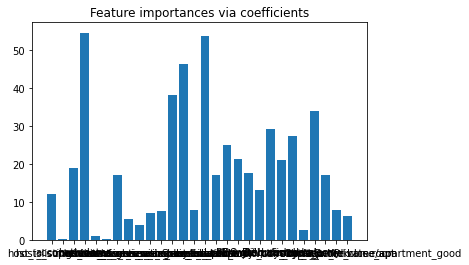

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import RidgeCV

ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y_train)
importance = np.abs(ridge.coef_)
feature_names = np.array(Numerical_predictors)

plt.bar(height=importance, x=feature_names)
plt.title("Feature importances via coefficients")
plt.show()

In [10]:
from sklearn.feature_selection import SelectFromModel
from time import time

threshold = np.sort(importance)[-10] + 0.01

tic = time()
sfm = SelectFromModel(ridge, threshold=threshold).fit(X_train, y_train)
toc = time()
print(f"Features selected by SelectFromModel: {feature_names[sfm.get_support()]}")
print(f"Done in {toc - tic:.3f}s")

Features selected by SelectFromModel: ['bathrooms' 'review_scores_location' 'review_scores_value'
 'Shared_bathroom' 'shared_room' 'BBQ grill' 'Dishwasher' 'city_Chicago'
 'city_New York']
Done in 0.037s


/Users/Jbollini/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_ridge.py:1791: RuntimeWarning: invalid value encountered in reciprocal
  w = ((singvals_sq + alpha) ** -1) - (alpha ** -1)


### Sequential Feature Selection to determine how many and which features to use

In [11]:
from sklearn.linear_model import RidgeCV
from sklearn.feature_selection import SequentialFeatureSelector
import warnings
warnings.filterwarnings('ignore')



def FeatSelect_choose(X_train,X_test,y,preds,k=10):
    
    ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y)
    feature_names = np.array(preds)
    
    sfs_forward = SequentialFeatureSelector(
        ridge, n_features_to_select=k, direction="forward"
    ).fit(X_train,y)
    
    X_train_10 = sfs_forward.transform(X_train)
    
    # validate :
    ridge_test = RidgeCV().fit(X_train_10, y)
    pred_ = ridge_test.predict(X_train_10)

    def rmse_accuracy_percentage(a,b):
        rmse = np.round(np.sqrt(sum(((np.array(a)-np.array(b))**2))/len(a)),2)
        print("RMSE is:",rmse)
        return rmse
    
    score = rmse_accuracy_percentage(y_train,pred_)
    
    return score,X_train_10,feature_names[sfs_forward.get_support()]
    
dict_scores = {}
for kk in range(1,len(Numerical_predictors)):
    score,X_train_10,features_fwd=  FeatSelect_choose(X_train,X_test,y_train,Numerical_predictors,k=kk)
    dict_scores[kk] = score

RMSE is: 134.7
RMSE is: 131.54
RMSE is: 127.43
RMSE is: 126.43
RMSE is: 125.57
RMSE is: 124.47
RMSE is: 123.92
RMSE is: 123.36
RMSE is: 122.3
RMSE is: 121.78
RMSE is: 121.5
RMSE is: 121.28
RMSE is: 121.06
RMSE is: 120.9
RMSE is: 120.79
RMSE is: 120.76
RMSE is: 120.72
RMSE is: 120.64
RMSE is: 120.61
RMSE is: 120.55
RMSE is: 120.53
RMSE is: 120.5
RMSE is: 120.48
RMSE is: 120.47
RMSE is: 120.47
RMSE is: 120.47
RMSE is: 120.47


#### Elbow rule

[Text(0.5, 1.0, 'Score by predictors count'),
 Text(0.5, 0, 'Pred Counts'),
 Text(0, 0.5, 'RMSE')]

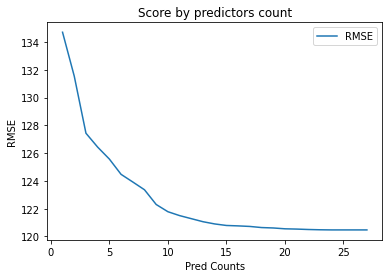

In [12]:
import seaborn as sns
score_df = pd.DataFrame.from_dict(dict_scores, orient='index',columns=['RMSE'])
score_df                                
sns.lineplot(data=score_df).set(title='Score by predictors count',
                                xlabel='Pred Counts', ylabel='RMSE')
                               

In [13]:
def FeatSelect(X_train,X_test,y,preds,k=9):
    
    ridge = RidgeCV(alphas=np.logspace(-6, 6, num=5)).fit(X_train, y)
    feature_names = np.array(preds)
    
    sfs_forward = SequentialFeatureSelector(
        ridge, n_features_to_select=k, direction="forward"
    ).fit(X_train,y)
    

    sfs_backward = SequentialFeatureSelector(
        ridge, n_features_to_select=k, direction="backward"
    ).fit(X_train,y)

    print(
        "Features selected by forward sequential selection: "
        f"{feature_names[sfs_forward.get_support()]}"
    )
    print(
        "Features selected by backward sequential selection: "
        f"{feature_names[sfs_backward.get_support()]}"
    )
    
    X_train_10 = sfs_forward.transform(X_train)
    X_test_10 = sfs_forward.transform(X_test)

    
    return X_train_10,X_test_10,feature_names[sfs_forward.get_support()],feature_names[sfs_backward.get_support()]

    
X_train_10,X_test_10,features_fwd,features_bwd=  FeatSelect(X_train,X_test,y_train,Numerical_predictors,k=9)


Features selected by forward sequential selection: ['host_listings_count' 'accommodates' 'bathrooms' 'review_scores_location'
 'review_scores_value' 'Shared_bathroom' 'entire_property' 'Dishwasher'
 'city_New York']
Features selected by backward sequential selection: ['host_listings_count' 'accommodates' 'bathrooms' 'review_scores_location'
 'review_scores_value' 'Shared_bathroom' 'entire_property' 'Dishwasher'
 'city_New York']


### How are prices distributed?

<AxesSubplot:xlabel='price', ylabel='Count'>

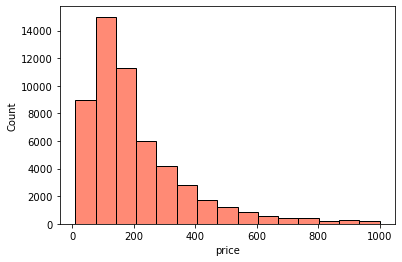

In [14]:
import seaborn as sns
sns.histplot(data=model_data_clean, x="price",bins = 15,color='tomato',
            line_kws={'color': 'black'})

### Option 1 : Gamma distribution GLM 

In [15]:
import statsmodels.api as sm
X_train_10_const = sm.add_constant(X_train_10, prepend=False)
gamma_model = sm.GLM(y_train,X_train_10_const, family=sm.families.Gamma())
gamma_results = gamma_model.fit()

/Users/Jbollini/opt/anaconda3/lib/python3.9/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [16]:
gamma_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  price   No. Observations:                37880
Model:                            GLM   Df Residuals:                    37870
Model Family:                   Gamma   Df Model:                            9
Link Function:          inverse_power   Scale:                         0.40675
Method:                          IRLS   Log-Likelihood:            -2.4058e+05
Date:                Wed, 07 Dec 2022   Deviance:                       23889.
Time:                        18:07:17   Pearson chi2:                 1.54e+04
No. Iterations:                    11   Pseudo R-squ. (CS):            -0.3007
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1         -1.477e-06   1.57e-08    -93.964      0.000   -1.51e-06   -1.45e-06
x2            -0.0003   1.22e-06   -222.753      0.000      -0.000      -0.000
x3            -0.0008   3.86e-06   -194.923      0.000      -0.001      -0.001
x4            -0.0008   5.82e-06   -145.200      0.000      -0.001      -0.001
x5             0.0011   6.94e-06    154.867      0.000       0.001       0.001
x6             0.0048   9.06e-05     53.442      0.000       0.005       0.005
x7            -0.0014   3.32e-05    -42.164      0.000      -0.001      -0.001
x8            -0.0008   8.16e-06    -99.131      0.000      -0.001      -0.001
x9            -0.0010   9.79e-06   -102.789      0.000      -0.001      -0.001
const          0.0082   4.19e-05    194.902      0.000       0.008       0.008
==============================================================================
"""

### Option 2: OLS - log transform of price

<AxesSubplot:xlabel='log_price', ylabel='Count'>

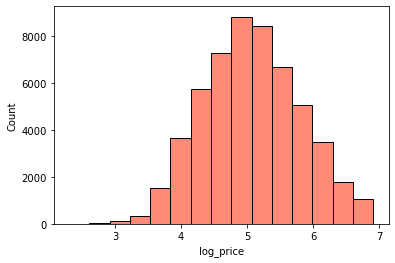

In [17]:
model_data_clean['log_price'] = log(model_data_clean['price'])

# define the selective transforms
from sklearn.preprocessing import StandardScaler

sns.histplot(data=model_data_clean, x='log_price',bins = 15,color="tomato",
            line_kws={'color': 'black'})


In [18]:
# Log transform and standard scale
def log_transform(arr):
    log_arr = log(arr)
    log_arr = (log_arr - mean(log_arr))/std(log_arr)
    return log_arr

y_log_train = log_transform(y_train)
y_log_test = log_transform(y_test)

In [19]:
## For Presentation

[Text(0.5, 0, 'Norm Log Price')]

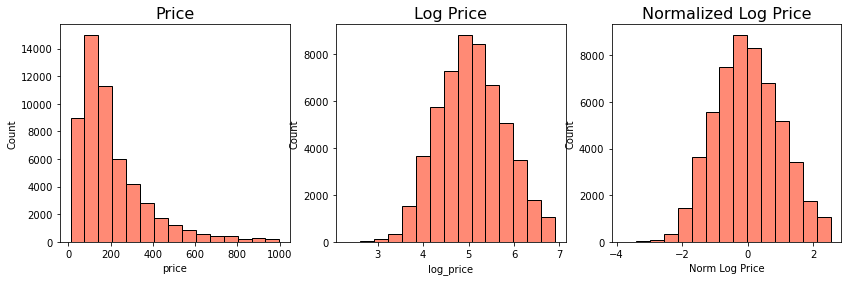

In [20]:
sns.mpl.rcParams['figure.figsize'] = (14, 4)
fig, ax = plt.subplots(1,3)

sns.histplot(data=model_data_clean, x="price", ax=ax[0],bins = 15,color='tomato',
            line_kws={'color': 'black'})
ax[0].set_title('Price', fontsize=16)
sns.histplot(data=model_data_clean, x='log_price', ax=ax[1], bins = 15,color="tomato",
            line_kws={'color': 'black'})

ax[1].set_title('Log Price', fontsize=16)
#ax[2].set(xlabel='Price', ylabel='Residuals')

sns.histplot(np.concatenate((y_log_train,y_log_test),axis=0), ax=ax[2], bins = 15,color='tomato',line_kws={'color': 'black'})
ax[2].set_title('Normalized Log Price', fontsize=16)
ax[2].set(xlabel='Norm Log Price')     
    


In [21]:
print(features_fwd)

linear_model = sm.OLS(y_log_train,X_train_10_const)

linear_results = linear_model.fit()
linear_results.summary()

['host_listings_count' 'accommodates' 'bathrooms' 'review_scores_location'
 'review_scores_value' 'Shared_bathroom' 'entire_property' 'Dishwasher'
 'city_New York']


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.546
Model:                            OLS   Adj. R-squared:                  0.545
Method:                 Least Squares   F-statistic:                     5051.
Date:                Wed, 07 Dec 2022   Prob (F-statistic):               0.00
Time:                        18:07:17   Log-Likelihood:                -38813.
No. Observations:               37880   AIC:                         7.765e+04
Df Residuals:                   37870   BIC:                         7.773e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0007   2.76e-05     24.139      0.000       0.001       0.001
x2             0.1152      0.002     65.370      0.000       0.112       0.119
x3             0.1981      0.006     32.084      0.000       0.186       0.210
x4             0.2316      0.008     27.877      0.000       0.215       0.248
x5            -0.2704      0.009    -31.788      0.000      -0.287      -0.254
x6            -0.6187      0.012    -50.901      0.000      -0.642      -0.595
x7             0.4633      0.011     42.817      0.000       0.442       0.484
x8             0.2515      0.008     31.765      0.000       0.236       0.267
x9             0.2804      0.007     37.468      0.000       0.266       0.295
const         -0.9610      0.015    -65.962      0.000      -0.990      -0.932
==============================================================================
Omnibus:                     1524.000   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2384.195
Skew:                           0.370   Prob(JB):                         0.00
Kurtosis:                       3.982   Cond. No.                         665.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
X_test_10_const = sm.add_constant(X_test_10, prepend=False)
predictions1 = linear_results.predict(X_test_10_const)
predictions2 = linear_results.predict(X_train_10_const)

def rmse_accuracy_percentage(a,b):
    print("RMSE is:",np.round(np.sqrt(sum(((np.array(a)-np.array(b))**2))/len(a)),2))
    
rmse_accuracy_percentage(y_log_test,predictions1)    
rmse_accuracy_percentage(y_log_train,predictions2)    

RMSE is: 0.67
RMSE is: 0.67


### Linearity test

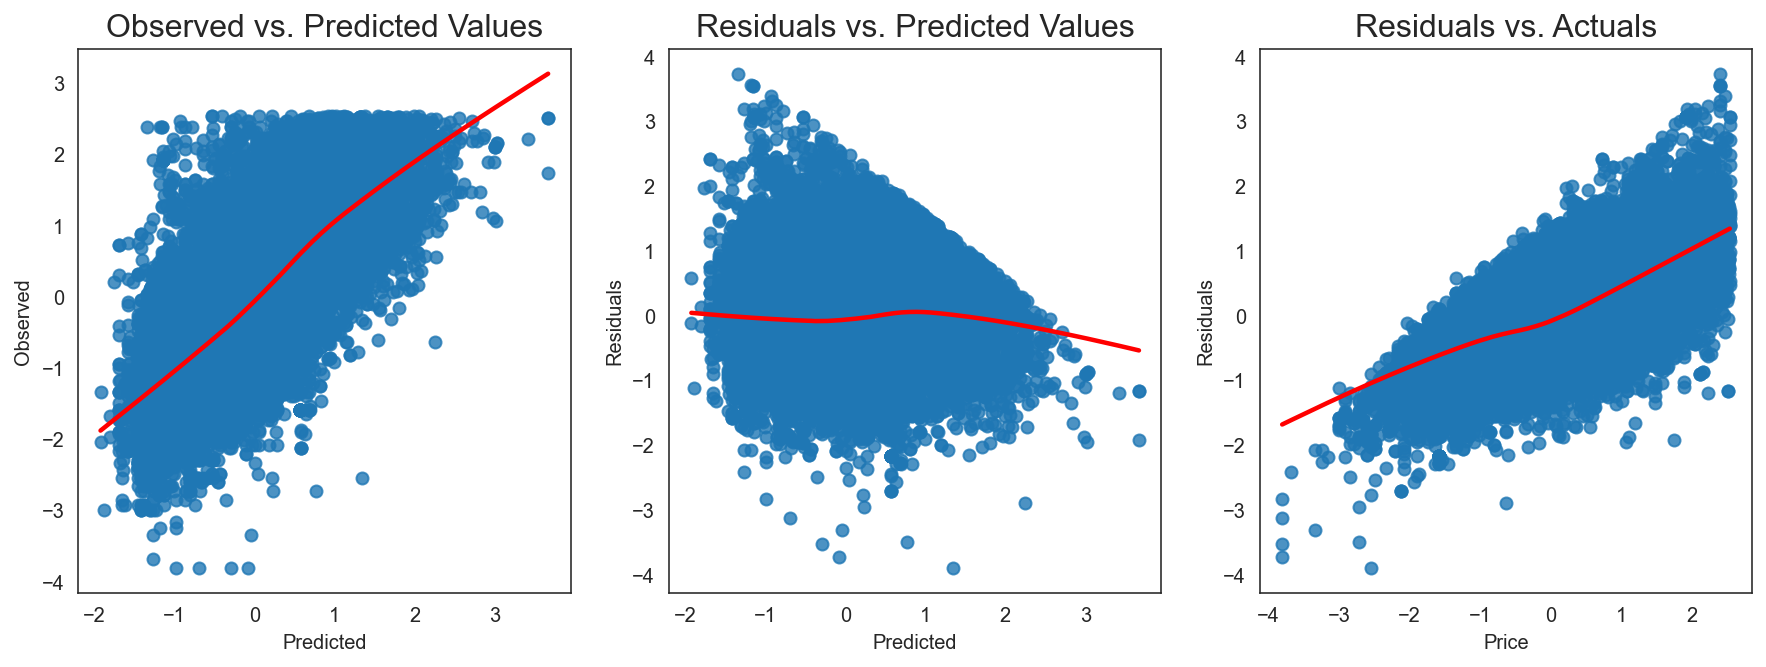

In [26]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import matplotlib.pyplot as plt
import statsmodels.stats.api as sms
sns.set_style('white')
sns.mpl.rcParams['figure.figsize'] = (15.0, 5)

def linearity_test(model, y):
    '''
    Function for visually inspecting the assumption of linearity in a linear regression model.
    It plots observed vs. predicted values and residuals vs. predicted values.
    
    Args:
    * model - fitted OLS model from statsmodels
    * y - observed values
    '''
    fitted_vals = model.predict()
    resids = model.resid

    fig, ax = plt.subplots(1,3)
    
    sns.regplot(x=fitted_vals, y=y, lowess=True, ax=ax[0], line_kws={'color': 'red'})
    ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
    ax[0].set(xlabel='Predicted', ylabel='Observed')

    sns.regplot(x=fitted_vals, y=resids, lowess=True, ax=ax[1], line_kws={'color': 'red'})
    ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
    ax[1].set(xlabel='Predicted', ylabel='Residuals')
    
    # Homoscedasticity check 
    sns.regplot(x=y, y=resids, lowess=True, ax=ax[2], line_kws={'color': 'red'})
    ax[2].set_title('Residuals vs. Actuals', fontsize=16)
    ax[2].set(xlabel='Price', ylabel='Residuals')
    
linearity_test(linear_results, y_log_train) 

## Quantile Regression - to deal with Heteroscedasticy

In [28]:
from statsmodels.regression.quantile_regression import QuantReg
mod = QuantReg(y_log_train,X_train_10_const)

print(f'Features are {features_bwd}')


for qq in [0.33,0.66,0.99]:
    res = mod.fit(q=qq)
    print(res.summary())
    
    predictions2 = res.predict(X_train_10_const)
    rmse_accuracy_percentage(y_log_train,predictions2) 
    
    predictions1 = res.predict(X_test_10_const)
    rmse_accuracy_percentage(y_log_test,predictions1)    
      

Features are ['host_listings_count' 'accommodates' 'bathrooms' 'review_scores_location'
 'review_scores_value' 'Shared_bathroom' 'entire_property' 'Dishwasher'
 'city_New York']
                         QuantReg Regression Results                          
Dep. Variable:                  price   Pseudo R-squared:               0.3672
Model:                       QuantReg   Bandwidth:                     0.08419
Method:                 Least Squares   Sparsity:                        1.616
Date:                Wed, 07 Dec 2022   No. Observations:                37880
Time:                        20:20:40   Df Residuals:                    37870
                                        Df Model:                            9
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0007   3.28e-05     20.553      0.000       0.001       0.001
x2             0.1074      0.002

In [29]:
predictions_ols = res.predict(X_test_10_const)

def rmse_accuracy_percentage(a,b):
    print("RMSE is:",np.round(np.sqrt(sum(((np.array(a)-np.array(b))**2))/len(a)),2))
    
rmse_accuracy_percentage(y_log_test,predictions_ols)    

RMSE is: 1.96


## Mixed Model by City and Entire vs shared property

Documentation : https://www.statsmodels.org/dev/examples/notebooks/generated/mixed_lm_example.html

In [30]:
# I will need to redefine my numerical variables now including 'city' that will be my groups
# I will remove the dummies by city 

vars_for_mixed_model = ['host_is_superhost', 'host_listings_count', 
                        'accommodates', 'bathrooms',
                        'minimum_nights','number_of_reviews', 'review_scores_rating', 'review_scores_accuracy',
                       'review_scores_cleanliness', 'review_scores_checkin',
                       'review_scores_communication', 'review_scores_location',
                       'review_scores_value', 'instant_bookable', 'Shared_bathroom',
                       'shared_room', 'BBQ grill', 'TV', 'Lock on bedroom door',
                       'Dishwasher','Private patio or balcony',
                       'Smoke alarm','room_type_Entire home/apt',
                       'room_type_Private room',
                       'topic_comments_word_close_apartment_good',
                       'city_num','entire_property'
                       ]

Numerical_predictors_mixed = [x for x in vars_for_mixed_model if x not in (['city_num','entire_property'])]


model_data_clean['city_num'] = np.where(model_data_clean['city_Chicago'] == 1,1,0)
model_data_clean['city_num'] = np.where(model_data_clean['city_Los angeles'] == 1,2,model_data_clean['city_num'])
model_data_clean['city_num'] = np.where(model_data_clean['city_New York'] == 1,3,model_data_clean['city_num'])

In [31]:
# Split in train and test
# in this case we will use a stratified sample based in price buckets and city

group_vars = ['city_num','entire_property']

def Stratify_train_test_groups(data,response,preds,Stratify_with,group_vars = group_vars):
    
    data[preds] = data[preds].astype('int')
    X= np.array(data[preds])
    where_are_NaNs = isnan(X)
    X[where_are_NaNs] = 0
    y = data[response]

    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=.3,
                                                        stratify=np.array(\
                                                        data[Stratify_with]),
                                                        random_state=1121218)
    
    # Remove the groups variables
    X_test_mixed_25 = X_test[:,:-2]
    X_train_mixed_25 = X_train[:,:-2]
    # build the groups dataframe
    train_group = X_train[:,[-2,-1]]
    train_group_df = pd.DataFrame(train_group, columns = group_vars)
    train_group_df[group_vars] = train_group_df[group_vars].astype(str)
    train_group_df['concat'] = train_group_df[group_vars[0]].str.cat(train_group_df[group_vars[1]], sep='_')
    
    test_group = X_test[:,[-2,-1]]
    test_group_df = pd.DataFrame(test_group, columns = group_vars)
    test_group_df[group_vars] = test_group_df[group_vars].astype(str)
    test_group_df['concat'] = test_group_df[group_vars[0]].str.cat(test_group_df[group_vars[1]], sep='_')
    
    
    return X_train_mixed_25, X_test_mixed_25, y_train, y_test,train_group_df,test_group_df




In [32]:
Stratify_with = ['city_Chicago','city_Los angeles','city_New York']
group_vars = ['city_num','entire_property']

X_train_mixed_25, X_test_mixed_25, y_train_mixed, y_test_mixed,train_group_df,test_group_df = Stratify_train_test_groups(model_data_clean,
                                                                               'price',
                                                                               vars_for_mixed_model,
                                                                               Stratify_with)


y_log_train_mixed = log_transform(y_train_mixed)
y_log_test_mixed = log_transform(y_test_mixed)

In [33]:
X_train_mixed_10,X_test_mixed_10,features_mixed_fwd,features_mixed_bwd = FeatSelect(X_train_mixed_25,
                                                                                    X_test_mixed_25,
                                                                                    y_log_train_mixed,
                                                                                    Numerical_predictors_mixed,
                                                                                    k=10
                                                                                   )

Features selected by forward sequential selection: ['host_listings_count' 'accommodates' 'bathrooms' 'review_scores_value'
 'Shared_bathroom' 'shared_room' 'TV' 'Dishwasher'
 'room_type_Entire home/apt' 'topic_comments_word_close_apartment_good']
Features selected by backward sequential selection: ['host_listings_count' 'accommodates' 'bathrooms' 'review_scores_location'
 'review_scores_value' 'Shared_bathroom' 'shared_room' 'TV' 'Dishwasher'
 'room_type_Entire home/apt']


### Mixed model with random intercept

In [34]:
# groups for mixed model will be 'entire_property',city_num

print(f'Features selected are {features_mixed_bwd}')

model = sm.MixedLM(y_log_train_mixed,X_train_mixed_10, train_group_df['concat'])
result = model.fit()
test = result.summary()

Features selected are ['host_listings_count' 'accommodates' 'bathrooms' 'review_scores_location'
 'review_scores_value' 'Shared_bathroom' 'shared_room' 'TV' 'Dishwasher'
 'room_type_Entire home/apt']


In [35]:
print(test)

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: price      
No. Observations: 37880   Method:             REML       
No. Groups:       6       Scale:              0.4487     
Min. group size:  1308    Log-Likelihood:     -38633.7433
Max. group size:  12172   Converged:          Yes        
Mean group size:  6313.3                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
x1             0.001    0.000  24.011 0.000  0.001  0.001
x2             0.110    0.002  62.226 0.000  0.107  0.114
x3             0.193    0.006  31.213 0.000  0.181  0.206
x4            -0.046    0.003 -18.313 0.000 -0.051 -0.041
x5            -0.600    0.013 -47.793 0.000 -0.624 -0.575
x6            -0.502    0.031 -15.952 0.000 -0.564 -0.441
x7             0.177    0.010  17.619 0.000  0.157  0.196
x8             0.254    

In [36]:
predictions_mixed = result.predict(X_train_mixed_10)
def rmse_accuracy_percentage(a,b):
    
    print("RMSE is:",np.round(np.sqrt(sum(((np.array(a)-np.array(b))**2))/len(a)),2))
    print("MAPE is:",np.round(np.sum(np.abs(np.array(a)-np.array(b)))/len(a),2))
    print("rmse norm:",np.linalg.norm(a - b) / np.sqrt(len(a)))
    
rmse_accuracy_percentage(y_log_train_mixed,predictions_mixed)

RMSE is: 0.86
MAPE is: 0.68
rmse norm: 0.8628511416444752


In [37]:
predictions_mixed = result.predict(X_test_mixed_10)
def rmse_accuracy_percentage(a,b):
    print("RMSE is:",np.round(np.sqrt(sum(((np.array(a)-np.array(b))**2))/len(a)),2))
    print("MAPE is:",np.round(np.sum(np.abs(np.array(a)-np.array(b)))/len(a),2))
    print("rmse norm:",np.linalg.norm(a - b) / np.sqrt(len(a)))
    
rmse_accuracy_percentage(y_log_test_mixed,predictions_mixed)

RMSE is: 0.86
MAPE is: 0.68
rmse norm: 0.8617885144146437


In [39]:
# groups for mixed model will be 'entire_property',city_num

print(f'Features selected are {features_mixed_bwd}')

model = sm.MixedLM(y_log_test_mixed,X_test_mixed_10, test_group_df['concat'])
result = model.fit()
print(result.summary())

Features selected are ['host_listings_count' 'accommodates' 'bathrooms' 'review_scores_location'
 'review_scores_value' 'Shared_bathroom' 'shared_room' 'TV' 'Dishwasher'
 'room_type_Entire home/apt']
          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: price      
No. Observations: 16235   Method:             REML       
No. Groups:       6       Scale:              0.4442     
Min. group size:  560     Log-Likelihood:     -16506.3616
Max. group size:  5193    Converged:          Yes        
Mean group size:  2705.8                                 
---------------------------------------------------------
              Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------
x1             0.001    0.000  17.009 0.000  0.001  0.001
x2             0.116    0.003  44.893 0.000  0.111  0.121
x3             0.162    0.009  18.677 0.000  0.145  0.179
x4            -0.048    0.004 -12.580 0.000 -0.055 -0.04